# Test of repetitive control

PH, June 2019


Repetitive control connected to a simple process:

* fast 1st order dyn
* static gain=0.8
<img src='testCtrl.png' width='50%'>

dependencies to run OM and load results

* OMPython: [OMPython doc](https://openmodelica.org/doc/OpenModelicaUsersGuide/latest/ompython.html)
* DyMat: https://pypi.org/project/DyMat/, [Tuto DyMat](https://www.fabrice-salvaire.fr/en/blog/first-steps-with-openmodelica/)

In [1]:
from pathlib import Path
import os
import subprocess

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from OMPython import OMCSessionZMQ, ModelicaSystem

In [3]:
import DyMat

Launch OpenModelica test

In [4]:
omc = OMCSessionZMQ()

2019-06-24 17:20:35,502 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.pierre.port.3a66c4a99d6249fbb6f47135ba9c93dd pid=23246


OpenModelica version:

In [5]:
omc.sendExpression("getVersion()")

'OpenModelica 1.13.2'

## Load model

Change current working directory to `./tmp` to avoid file clutter

In [6]:
os.chdir('tmp')

In [7]:
f = Path('../MagneticTestCtrl.mo')

Load and build model

In [8]:
mod = ModelicaSystem(f.absolute(), 'MagneticTestCtrl.tests.testCtrl')

2019-06-24 17:20:42,134 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.pierre.port.e6acff05c8f044299ef85af570700dd1 pid=23264


Notification: Automatically loaded package Modelica 3.2.2 due to uses annotation.
Notification: Automatically loaded package Complex 3.2.2 due to uses annotation.
Notification: Automatically loaded package ModelicaServices 3.2.2 due to uses annotation.



In [9]:
mod.modelName

'MagneticTestCtrl.tests.testCtrl'

In [10]:
mod.getParameters()

{'addPert.k1': 1.0,
 'addPert.k2': 1.0,
 'addSin.k1': 1.0,
 'addSin.k2': 1.0,
 'gainPert.k': 1.0,
 'magCtrl.add.k1': 1.0,
 'magCtrl.add.k2': 1.0,
 'magCtrl.addFF.k1': 1.0,
 'magCtrl.addFF.k2': 1.0,
 'magCtrl.delay.delayTime': 1.0,
 'magCtrl.f0': 50.0,
 'magCtrl.fc': 1000.0,
 'magCtrl.firstOrder.T': 1.0,
 'magCtrl.firstOrder.k': 1.0,
 'magCtrl.firstOrder.y_start': 0.0,
 'magCtrl.gain.k': 1.0,
 'magCtrl.k': 1.0,
 'magCtrl.td': None,
 'process.T': 1e-05,
 'process.k': 0.8,
 'process.y_start': 0.0,
 'ref.amplitude': 2.0,
 'ref.offset': -1.0,
 'ref.period': 0.02,
 'ref.startTime': 0.0,
 'ref.width': 50.0,
 'refFilter.T': 1e-05,
 'refFilter.k': 1.0,
 'refFilter.y_start': 0.0,
 'sineF1.amplitude': 1.0,
 'sineF1.freqHz': 50.0,
 'sineF1.offset': 0.0,
 'sineF1.phase': 1.5708,
 'sineF1.startTime': 0.0,
 'sineF3.amplitude': 1.0,
 'sineF3.freqHz': 150.0,
 'sineF3.offset': 0.0,
 'sineF3.phase': 0.0,
 'sineF3.startTime': 0.0,
 'magCtrl.firstOrder.initType': 1.0,
 'process.initType': 1.0,
 'ref.nperio

## A first simulation

How to change parameters:

In [11]:
mod.setParameters(**{'gainPert.k':1})

In [13]:
mod.getParameters('gainPert.k', 'sineF1.freqHz') # nb : bug when asking for just one param (https://github.com/OpenModelica/OMPython/issues/96)

(1.0, 50.0)

In [14]:
mod.getSimulationOptions()

{'startTime': 0.0,
 'stopTime': 0.2,
 'stepSize': 1e-05,
 'tolerance': 1e-06,
 'solver': 'dassl'}

set the step size

In [50]:
mod.setSimulationOptions(stepSize = 1e-6)

Simulate:

In [17]:
mod.simulate() # does nothing..

Fixed simulate method:

In [19]:
def simulate(mod):
    r = subprocess.run([Path(mod.modelName).absolute()], capture_output=True)
    print(r.stdout.decode())
    return r

In [52]:
simulate(mod);

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.



### get results

* using getSolutions: too long
* much faster with DynMat

In [97]:
# ym = mod.getSolutions('magCtrl.ym') ## too long

In [24]:
res = DyMat.DyMatFile('MagneticTestCtrl.tests.testCtrl_res.mat')

In [25]:
t = res.abscissa('magCtrl.ym')[0]
t= t*1000 # -> ms
u = res.data('process.u')
ym = res.data('magCtrl.ym')
ysp = res.data('magCtrl.ysp')

Plot simulation with zoom on last period

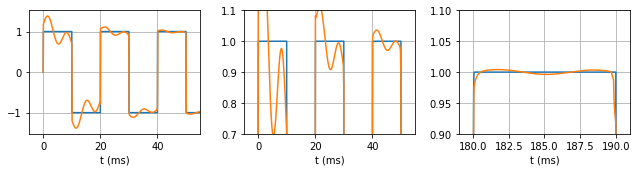

In [62]:
def plot_res(res, axes=None):
    t = res.abscissa('magCtrl.ym')[0]
    t= t*1000 # -> ms
    u = res.data('process.u')
    ym = res.data('magCtrl.ym')
    ysp = res.data('magCtrl.ysp')
    
    if not axes:
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,2.5))
    else:
        ax1, ax2 = axes
        fig = ax1.get_figure()

    def plot_data(ax):
        ax.plot(t,ysp)
        ax.plot(t,ym)
        #ax.plot(t,u)

        ax.grid()
        ax.set(
            xlabel='t (ms)'
        )

    plot_data(ax1)
    ax1.set(
        xlim = (-5,55),
    )
    plot_data(ax2)
    ax2.set(
        xlim = (-5,55),
        ylim = (0.7, 1.1)
    )
    plot_data(ax3)
    ax3.set(
        xlim = (179,191),
        ylim = (0.9, 1.1)
    )
    fig.tight_layout()

plot_res(res)

## Parametric analysis

Nominal params

In [54]:
params = {
    'gainPert.k': 1.0,
    'magCtrl.k': 1.0,
    'magCtrl.fc': 1e3,
}

In [55]:
variants = {'nom': params}

variants:

* no perturbation
* higher feedback gain K=3

In [56]:
variants['nopert'] = params.copy()
variants['nopert']['gainPert.k'] = 0.

variants['nopert_HK'] = variants['nopert'].copy()
variants['nopert_HK']['magCtrl.k'] = 3

variants['HK'] = params.copy()
variants['HK']['magCtrl.k'] = 3

In [57]:
variants

{'nom': {'gainPert.k': 1.0, 'magCtrl.k': 1.0, 'magCtrl.fc': 1000.0},
 'nopert': {'gainPert.k': 0.0, 'magCtrl.k': 1.0, 'magCtrl.fc': 1000.0},
 'nopert_HK': {'gainPert.k': 0.0, 'magCtrl.k': 3, 'magCtrl.fc': 1000.0},
 'HK': {'gainPert.k': 1.0, 'magCtrl.k': 3, 'magCtrl.fc': 1000.0}}

Run all the simulations

In [58]:
res_dict = {}
for v in variants:
    mod.setParameters(**variants[v])
    simulate(mod)
    res = DyMat.DyMatFile(mod.modelName + '_res.mat')
    res_dict[v] = res
res_dict

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.

LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.
LOG_SUCCESS       | info    | The simulation finished successfully.



{'nom': <DyMat.DyMatFile at 0x7fb710a68be0>,
 'nopert': <DyMat.DyMatFile at 0x7fb7109f2748>,
 'nopert_HK': <DyMat.DyMatFile at 0x7fb70fdfe1d0>,
 'HK': <DyMat.DyMatFile at 0x7fb70fdf4ac8>}

Without perturbation

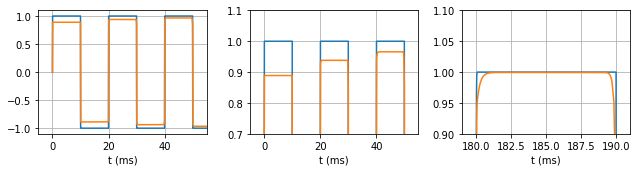

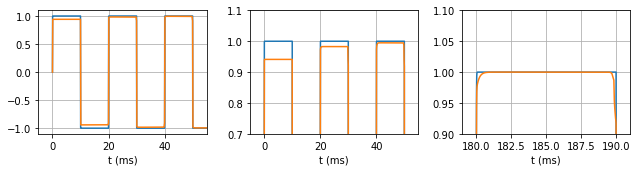

In [66]:
plot_res(res_dict['nopert'])
plt.savefig('../testCtrl_nopert.png', dpi=200)
plot_res(res_dict['nopert_HK'])
plt.savefig('../testCtrl_nopert_K3.png', dpi=200)

With perturbation

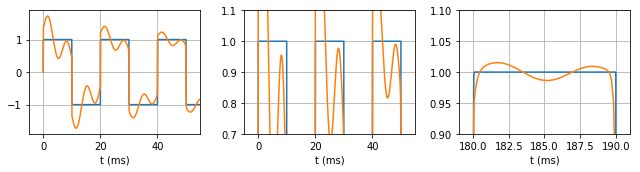

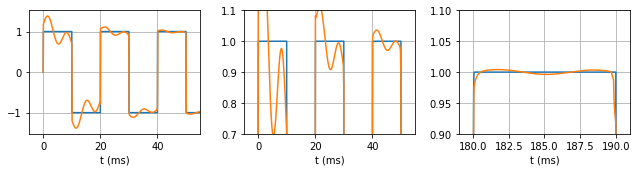

In [68]:
plot_res(res_dict['nom'])
plt.savefig('../testCtrl_pert.png', dpi=200)
plot_res(res_dict['HK'])
plt.savefig('../testCtrl_pert_K3.png', dpi=200)